In [1]:
%matplotlib inline
import pandas as pd, datetime as dt
import collections
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import glob, os

In [2]:
TA = 120  # g/km, the type-approval for this vehicle

## PN vs CO2

In [3]:
files = glob.glob('*C.xls')                                     # read lab files (-7C) 

dic = {}                                                            # empty dictionary lab test

i = 1
for each in files:
  
    %time df = pd.read_excel(each, sheetname=1, header=0)                          # read the proper sheets within each file

    v = df['DACtrl_ActualSpeed\n[kph]']                                # speed 
    t_s = len(df.index)                                                # time(s)
    t_m = t_s/60                                                       # time (min)
    t_h = t_s/3600                                                     # time (h)
    v_mean = v.mean()                                                  # speed means
    d = v_mean * t_h                                                   # distance means

    CO2 = df['c_CO2_Dil_g_vec\n[grams]']
    CO2_sum = CO2.sum()
    CO2km = CO2_sum/d                                                    # CO2 per km 
    #CO2pct = CO2km*100/CO2_TA                                            # emissions as % of type approval (98 g/km)

    flow_gas = df['c_Vmix_vec\n[m3/min]']                               # flow of gas mixture [m3/min]
    flow_avg = flow_gas.sum()/t_s                                       # average in m3/min
    vol_gas = flow_avg * t_m                                            # total volume of gas mixture (m3)
    vol_gas_cc = vol_gas * 1e6                                          # total volume of gas mixture (cm3)

    PN = df["Counter\n[cpcc]"]                                         # column of PN flow in #/cm3
    PN_sum = PN.sum()                                                  
    PN_avg = PN_sum / t_s                                               # average of flow in #/cm3
    
    PN_total = PN_avg * vol_gas_cc                                      # total emitted in #
    PN_total_km = PN_total / d                                          # total emission in #/km
    
    key = each.split('dal_')[1].split('.x')[0]                             # shortening the titles of the files
    
    key = str(i) + "." + str(key)                                        # numbering the files
    dic[key] = [CO2km, vol_gas_cc, t_s, t_m, d, PN_sum, PN_avg, PN_total_km] # save means in the dictionary 
    i = i+1

Wall time: 609 ms
Wall time: 882 ms
Wall time: 710 ms
Wall time: 422 ms
Wall time: 545 ms
Wall time: 697 ms
Wall time: 455 ms
Wall time: 456 ms
Wall time: 656 ms
Wall time: 560 ms
Wall time: 421 ms
Wall time: 645 ms
Wall time: 427 ms
Wall time: 663 ms
Wall time: 645 ms
Wall time: 645 ms
Wall time: 439 ms
Wall time: 693 ms


In [4]:
lab = pd.DataFrame()                                                          
lab = lab.from_dict(dic, orient='index')                                       # convert dic to dataframe
lab['ind2'] = ['04','08','07','04','06','11','01','05','11',
               '01','01','12','02','10','12','09','03','12']                                       # proper order
lab.columns = ['CO2km', 'vol_gas_cc', 't_s', 't_m', 'd', 'PN_sum', 'PN_avg', 'PN_total_km','ind2']               # headers
lab = lab.sort_values('ind2')

In [5]:
lab['test'] = ['N_CD_23','N_CD_23','N_CD_23','N_CD_10',
               'N_CD_30','N_CD_4W_23','N_CD_4W_23','N_HT_23',
               'N_HT_4W_23','W_CD_4W_23','W_HT_4W_23','W_CD_4W_30',
               'W_CD_4W_10','W_CD_0','W_CD_0','W_CD-7','W_CD-7','W_CD-7']

lab.columns = ['CO2km', 'vol_gas_cc', 't_s', 't_m', 'd', 'PN_sum', 'PN_avg', 'PN_total_km','ind2','test']
lab

,CO2km,vol_gas_cc,t_s,t_m,d,PN_sum,PN_avg,PN_total_km,ind2,test
7.NEDC_COLD_FWDsync_23C,151.067827,1.742864e+08,1181,19.683333,10.862547,5.193763e+06,4397.767010,7.056089e+10,01,N_CD_23
10.NEDC_COLD_FWDsync_23C,150.713390,1.748201e+08,1181,19.683333,10.771351,2.729454e+06,2311.138194,3.751000e+10,01,N_CD_23
11.NEDC_COLD_FWDsync_23C,151.297805,1.743031e+08,1181,19.683333,10.844199,3.112048e+06,2635.095883,4.235493e+10,01,N_CD_23
13.NEDC_COLD_FWDsync_10C,164.173048,1.748149e+08,1181,19.683333,10.830128,1.849032e+07,15656.496074,2.527199e+11,02,N_CD_10
17.NEDC_COLD_FWD-sync_30C,146.052706,1.739773e+08,1181,19.683333,10.847713,8.011821e+05,678.393007,1.088017e+10,03,N_CD_30
1.NEDC_COLD_4WD_23C,163.744091,1.727120e+08,1181,19.683333,10.898082,3.922350e+05,332.121101,5.263430e+09,04,N_CD_4W_23
4.NEDC_COLD_4WD_23C,168.048346,1.730071e+08,1180,19.666667,10.908547,4.446057e+06,3767.844816,5.975719e+10,04,N_CD_4W_23
8.NEDC_HOT_FWDsync_23C,143.619332,1.742289e+08,1181,19.683333,10.820741,8.418249e+05,712.806847,1.147717e+10,05,N_HT_23
5.NEDC_HOT_4WD_23C,155.630973,1.732372e+08,1181,19.683333,10.845672,4.326129e+06,3663.106488,5.851057e+10,06,N_HT_4W_23
3.WLTP_COLD_4WD_23c,175.949167,2.644113e+08,1801,30.016667,23.266507,1.392724e+08,77330.582833,8.788203e+11,07,W_CD_4W_23


In [6]:
name = lab.groupby(lab.ind2).mean()#.reset_index()#drop = True)
name['test'] = ['N_CD_23','N_CD_10','N_CD_30','N_CD_4W_23','N_HT_23','N_HT_4W_23',
               'W_CD_4W_23','W_HT_4W_23','W_CD_4W_30','W_CD_4W_10','W_CD_0','W_CD-7']
name.columns = ['CO2km', 'vol_gas_cc', 't_s', 't_m', 'd', 'PN_sum', 'PN_avg', 'PN_total_km','test']

name

,CO2km,vol_gas_cc,t_s,t_m,d,PN_sum,PN_avg,PN_total_km,test
ind2,,,,,,,,,
01,151.026341,1.744698e+08,1181.0,19.683333,10.826032,3.678422e+06,3114.667029,5.014194e+10,N_CD_23
02,164.173048,1.748149e+08,1181.0,19.683333,10.830128,1.849032e+07,15656.496074,2.527199e+11,N_CD_10
03,146.052706,1.739773e+08,1181.0,19.683333,10.847713,8.011821e+05,678.393007,1.088017e+10,N_CD_30
04,165.896218,1.728596e+08,1180.5,19.675000,10.903315,2.419146e+06,2049.982958,3.251031e+10,N_CD_4W_23
05,143.619332,1.742289e+08,1181.0,19.683333,10.820741,8.418249e+05,712.806847,1.147717e+10,N_HT_23
06,155.630973,1.732372e+08,1181.0,19.683333,10.845672,4.326129e+06,3663.106488,5.851057e+10,N_HT_4W_23
07,175.949167,2.644113e+08,1801.0,30.016667,23.266507,1.392724e+08,77330.582833,8.788203e+11,W_CD_4W_23
08,177.646725,2.625326e+08,1801.0,30.016667,23.290534,1.066781e+06,592.327316,6.676755e+09,W_HT_4W_23
09,164.460484,2.658630e+08,1801.0,30.016667,23.283650,4.395550e+06,2440.616127,2.786804e+10,W_CD_4W_30


## Plot all tests

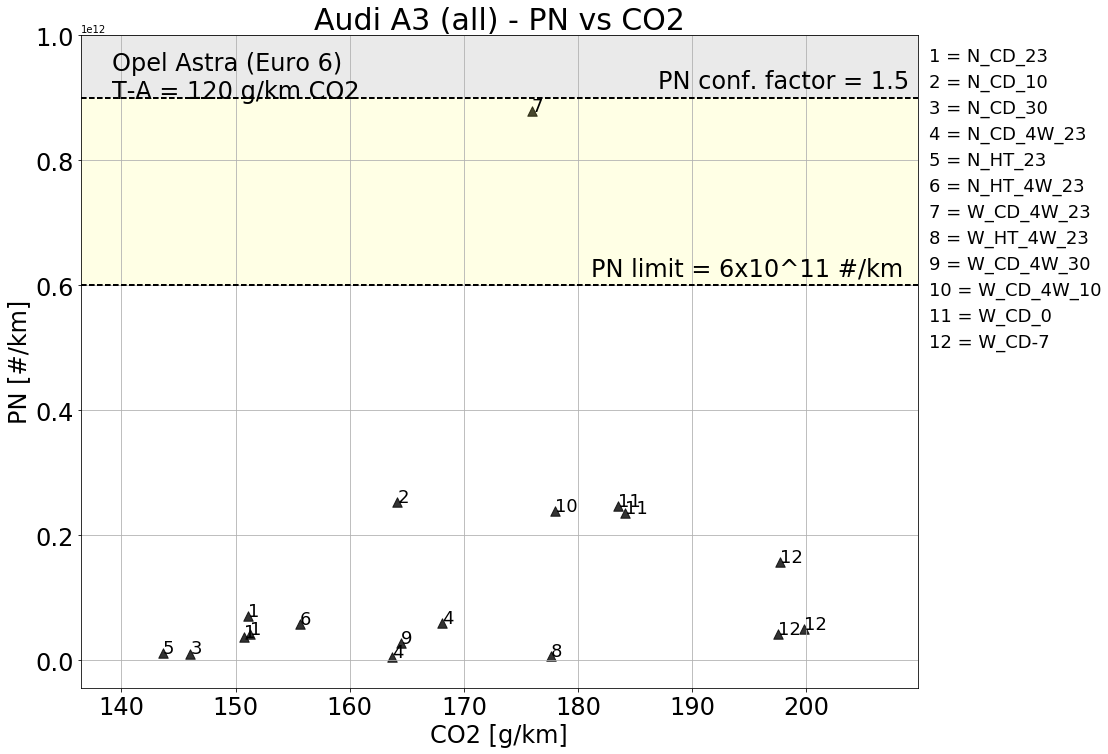

In [10]:
ax = lab.plot.scatter('CO2km', 'PN_total_km', marker="^", alpha=.8 ,s = 90, c = 'black', 
                      figsize=(15, 12), grid ='on')

# road.plot.scatter('CO2_COMP_','PN_COMP', ax=ax,  marker='*', s = 90, c = 'red', grid = 'on')
# road.plot.scatter('CO2_URB_','PN_URB', ax=ax, s = 60, alpha=.5, c = 'blue', grid = 'on')
# road.plot.scatter('CO2_RUR_','PN_RUR', ax=ax, s = 60, alpha=.5, c = 'green', grid = 'on')
# road.plot.scatter('CO2_MOT_','PN_MOT', ax=ax, s = 60, c = 'orange', grid = 'on')

# legend = ('LAB','ROAD (complete)','ROAD (urban)','ROAD (rural)','ROAD (motorway)')
# plt.legend(legend, fontsize = 16, loc = 'best')

# lim_inf_CO2 = min(lab.CO2km.min(),road.CO2_COMP_.min(), road.CO2_URB_.min(),
#                  road.CO2_RUR_.min(),road.CO2_MOT_.min()) -0.05*min(lab.CO2km.min(),
#                 road.CO2_COMP_.min(), road.CO2_URB_.min(), road.CO2_RUR_.min(),road.CO2_MOT_.min())
# lim_sup_CO2 = max(lab.CO2km.max(),road.CO2_COMP_.max(), road.CO2_URB_.max(),
#                  road.CO2_RUR_.max(),road.CO2_MOT_.max()) +0.05*max(lab.CO2km.max(),
#                 road.CO2_COMP_.max(), road.CO2_URB_.max(), road.CO2_RUR_.max(),road.CO2_MOT_.max())
# lim_inf_PN = min(lab.PN_total_km.min(),road.PN_COMP.min(), road.PN_URB.min(),
#                  road.PN_RUR.min(),road.PN_MOT.min()) -0.05*(max(lab.PN_total_km.min(),
#                 road.PN_COMP.min(), road.PN_URB.min(), road.PN_RUR.min(), road.PN_MOT.min()) -
#                 min(lab.PN_total_km.min(), road.PN_COMP.min(), road.PN_URB.min(), road.PN_RUR.min()
#                 , road.PN_MOT.min())                                                  )
# lim_sup_PN = max(lab.PN_total_km.max(),road.PN_COMP.max(), road.PN_URB.max(),
#                  road.PN_RUR.max(),road.PN_MOT.max()) +0.05*max(lab.PN_total_km.max(),
#                 road.PN_COMP.max(), road.PN_URB.max(), road.PN_RUR.max(),road.PN_MOT.max())

lim_inf_CO2 = lab.CO2km.min()-0.05*lab.CO2km.min()
lim_sup_CO2 = lab.CO2km.max()+0.05*lab.CO2km.max()
lim_inf_PN = -0.05*lab.PN_total_km.max()
lim_sup_PN = lab.PN_total_km.max()+0.05*lab.PN_total_km.max()

#lim_sup_PN = 1e12


fontsize = 24
plt.ylabel('PN [#/km]', fontsize = fontsize)
plt.xlabel('CO2 [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('Audi A3 (all) - PN vs CO2', fontsize = 30)
plt.axis([lim_inf_CO2,lim_sup_CO2,lim_inf_PN,lim_sup_PN])                             

if len(name)<10:
    for i, txt in enumerate(lab.ind2):
        ax.annotate(txt, (lab.CO2km.iat[i],lab.PN_total_km.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
else:
    for i, txt in enumerate(lab.ind2):
        if i<[i for i,x in enumerate(lab.ind2) if x == '10'][0]:
            ax.annotate(txt.split('0')[1], (lab.CO2km.iat[i],lab.PN_total_km.iat[i]), ha = 'left', fontsize = 18)#, rotation = 30)
        else:
            ax.annotate(txt, (lab.CO2km.iat[i],lab.PN_total_km.iat[i]), ha = 'left', fontsize = 18, clip_on=True)#, rotation = 30)

# for i, txt in enumerate(road.ALPH):
#     ax.annotate(txt + '', (road.CO2_COMP_.iat[i],road.PN_COMP.iat[i]), 
#                 ha = 'left', fontsize = 14, clip_on=True)
# for i, txt in enumerate(road.ALPH):
#     ax.annotate(txt + '', (road.CO2_URB_.iat[i],road.PN_URB.iat[i]), 
#                 ha = 'left', fontsize = 14, clip_on=True)
# for i, txt in enumerate(road.ALPH):
#     ax.annotate(txt + '', (road.CO2_RUR_.iat[i],road.PN_RUR.iat[i]), 
#                 ha = 'left', fontsize = 14, clip_on=True)
# for i, txt in enumerate(road.ALPH):
#     ax.annotate(txt + '', (road.CO2_MOT_.iat[i],road.PN_MOT.iat[i]), 
#                 ha = 'left', fontsize = 14, clip_on=True)   
    
i=1
for each in name.test:
    plt.gcf().text(0.91, 0.88 - 0.03*i, str(i) + ' = ' +  each, fontsize=18)  # 
    i = i+1

# i = 0
# for each in road.index:
#     plt.gcf().text(0.91, 0.45 - 0.03*i, road.ALPH[i] + ' = ' + each.split('001_')[1].split('_2017')[0] , fontsize=18)
#     i = i+1

if TA>lim_inf_CO2:
    ax.annotate('Audi A3 (Euro 6) \nT-A = ' + str(TA) + ' g/km CO2',
                (TA+0.02*TA, lim_sup_PN-0.1*lim_sup_PN), textcoords='data', fontsize=24, clip_on=True)
else:
    ax.annotate('Audi A3 (Euro 6) \nT-A = ' + str(TA) + ' g/km CO2',
                (lim_inf_CO2+0.02*lim_inf_CO2, lim_sup_PN-0.1*lim_sup_PN), textcoords='data', fontsize=24, clip_on=True)
    
ax.annotate('PN conf. factor = 1.5',(lim_sup_CO2 - 0.31*(lim_sup_CO2-lim_inf_CO2), 6.1*1.5*1e11),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('PN limit = 6x10^11 #/km',(lim_sup_CO2 - 0.39*(lim_sup_CO2-lim_inf_CO2), 6.15*1e11),
            textcoords='data', fontsize=24, clip_on=True)


plt.axvline(x=TA, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=6e11, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=6e11*1.5, color='k', linestyle='--', linewidth=2 )

plt.axhspan(6e11, 6e11*1.5 , facecolor='yellow', alpha=0.1)
plt.axhspan(6e11*1.5, lim_sup_PN , facecolor='0.2', alpha=0.1)
plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)